# Exploring Covid-19 with Google Big Query and Python

## Import the libraries used in this tutorial

In [13]:
from google.cloud import bigquery
import pandas as pd
import matplotlib as plt
import re
import plotly.figure_factory as ff
import plotly.express as px
import plotly as py
import numpy as np
import us
import pycountry as pyc

In [2]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = None

In [256]:
pd.options.display.width = 500

In [261]:
pd.options.display.expand_frame_repr = False

In [248]:
pd.options.display.max_colwidth = 1000

In [3]:
client = bigquery.Client(location="US")

## Some Helper Functions

In [4]:
def gcp_list_databases():
    rv = []
    for i in client.list_datasets('bigquery-public-data'):
        rv.append(i.dataset_id)
    return rv

In [5]:
def gcp_list_tables(database_name=None):
    rv = []
    if not None:
        for t in client.list_tables('bigquery-public-data.' + database_name):
            rv.append(t.table_id)
    return rv

In [89]:
def get_country_code(country):
    try:
        rv = pyc.countries.search_fuzzy(country)[0].alpha_3
    except:
        rv = None
    return rv

In [208]:
def clean_state_col(s):
    if ',' in s:
        rv = re.findall('(.*?), (.*)\ ?\(?', s)[0][1]
    else:
        rv = s
    return rv

In [215]:
def get_state_code(state):
    try:
        rv = us.states.lookup(state).abbr
    except:
        rv = None
    return rv

## Listing Tables and Databases/Datasets in the BQ Public Data

In [6]:
databases = gcp_list_databases()

In [7]:
for d in databases:
    if 'covid' in d:
        print(d)

covid19_jhu_csse
covid19_jhu_csse_eu


In [8]:
tables = gcp_list_tables('covid19_jhu_csse')
for t in tables:
    print(t)

confirmed_cases
deaths
recovered_cases
summary


## Convert the Summary Table into a Pandas DataFrame

In [9]:
query = """
    SELECT * 
    FROM `bigquery-public-data.covid19_jhu_csse.summary`
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

jhu_covid_summary = query_job.to_dataframe()

In [10]:
max_date = jhu_covid_summary['date'].max()
min_date = jhu_covid_summary['date'].min()

In [11]:
current_global_df = jhu_covid_summary[
    jhu_covid_summary['date'] == max_date
].copy()

In [262]:
current_global_df.head(3)

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key
169,None,MS Zaandam,2020-04-04,NaN,NaN,None,9.0,2.0,0.0,7.0,None,None,",,MS Zaandam"
841,None,Diamond Princess,2020-04-04,NaN,NaN,None,712.0,11.0,619.0,82.0,None,None,Diamond Princess
871,None,Namibia,2020-04-04,-22.9576,18.4904,POINT(18.4904 -22.9576),14.0,0.0,3.0,11.0,None,None,Namibia


## Looking at Cases on a Global Scale

In [213]:
death_to_cases_df = current_global_df \
    .groupby('country_region') \
    .agg({'confirmed': sum
          , 'deaths': sum}) \
    .reset_index() \
    .assign(death_to_cases=lambda r:r.deaths / r.confirmed) \
    .assign(country_code=lambda r: \
                r['country_region'].apply(get_country_code)) \
    .assign(log_confirmed=lambda s: np.log(s['confirmed'])) \
    .sort_values('death_to_cases', ascending=False)

In [94]:
death_to_cases_df_p = death_to_cases_df[
    death_to_cases_df['country_code'].notnull()
]
death_to_cases_df_p

,country_region,confirmed,deaths,death_to_cases,country_code,log_confirmed
63,Gambia,4.0,1.0,0.25,GMB,1.386294
22,Botswana,4.0,1.0,0.25,BWA,1.386294
156,Sudan,10.0,2.0,0.20,SDN,2.302585
4,Angola,10.0,2.0,0.20,AGO,2.302585
122,Nicaragua,5.0,1.0,0.20,NIC,1.609438


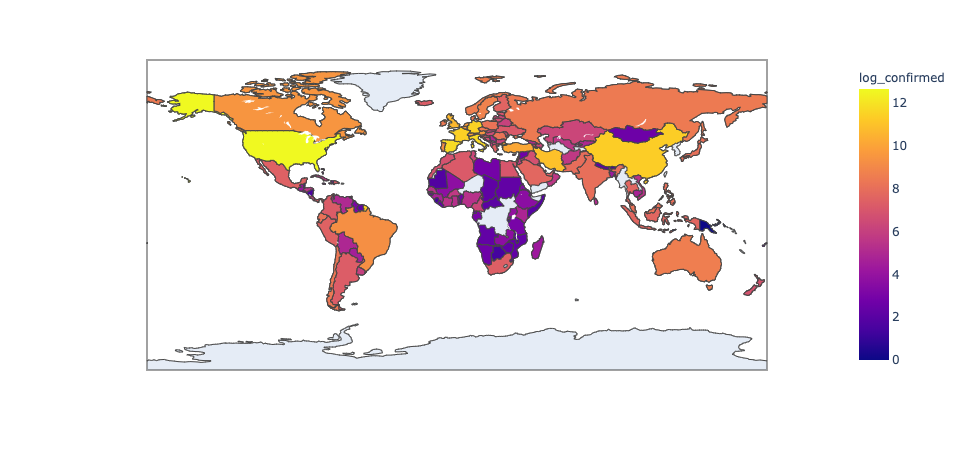

In [95]:
px.choropleth(death_to_cases_df_p, locations=death_to_cases_df_p['country_code']
              , color=death_to_cases_df_p['log_confirmed']
              , scope='world'
              , locationmode="ISO-3")

## Let's Look at The US Today by State

In [82]:
current_us_data = current_global_df[
    current_global_df['country_region'] == 'US'
].copy()

In [216]:
state_agg = current_us_data \
    .groupby('province_state') \
    .agg({'confirmed': sum
          , 'deaths': sum
          , 'recovered': sum}) \
    .sort_values('confirmed', ascending=False) \
    .reset_index() \
    .assign(abbr=lambda s: s['province_state'] \
                  .apply(lambda s: us.states.lookup(s).abbr if us.states.lookup(s) else None)) \
    .assign(is_continental=lambda s: s['province_state'] \
                  .apply(lambda s: us.states.lookup(s).is_continental if us.states.lookup(s) else False)) \
    .assign(deaths_to_cases=lambda r: r.deaths / r.confirmed) \
    .assign(recovered_to_cases=lambda r: r.recovered / r.confirmed) 

In [217]:
state_agg_p = state_agg[
    state_agg['is_continental'] 
] \
    .assign(log_confirmed=lambda s: np.log(s['confirmed'])) \
    .copy()

### Log of Cases Confirmed in the USA

Because New York is so disproportinal in the number of confirmed cases we need to use a logorithmic scale to get any insight into the other states.

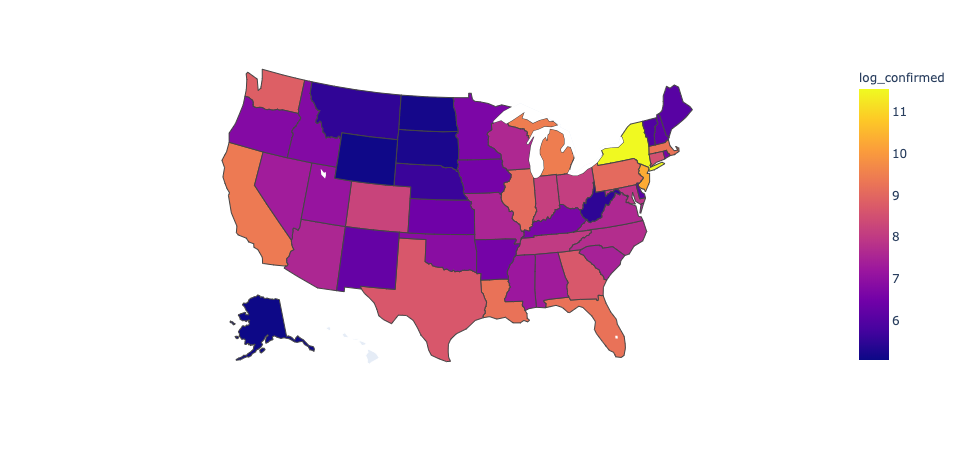

In [210]:
px.choropleth(state_agg_p, locations=state_agg_p['abbr']
              , color=state_agg_p['log_confirmed'], scope='usa', locationmode="USA-states")

### Deaths to Confirmed Cases in the USA

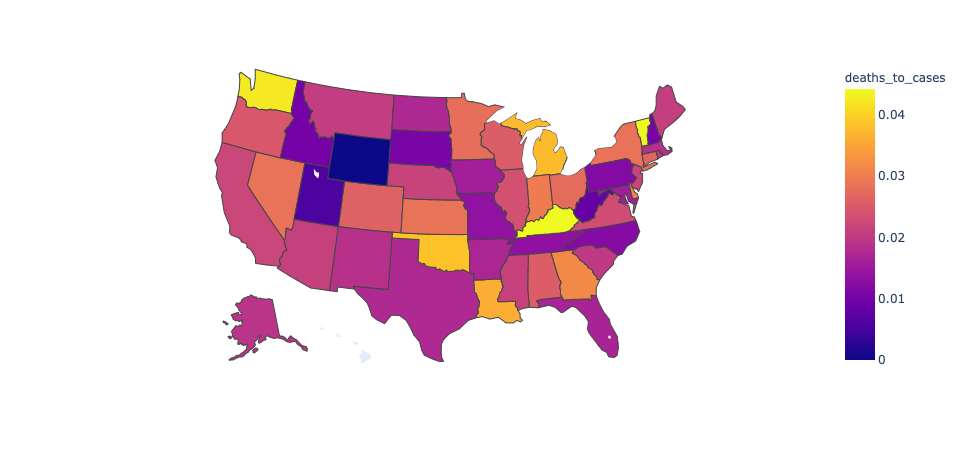

In [211]:
px.choropleth(state_agg_p, locations=state_agg_p['abbr']
              , color=state_agg_p['deaths_to_cases'], scope='usa', locationmode="USA-states")

### Recovered to Confirmed Cases in the USA

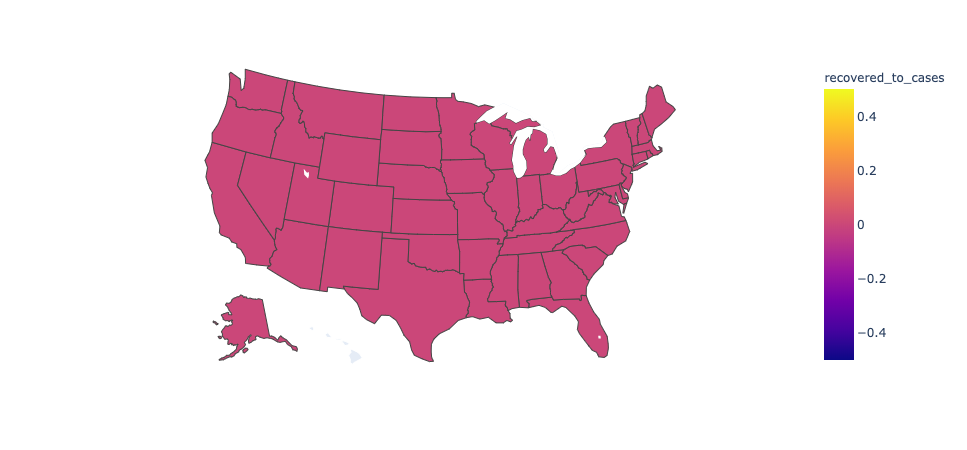

In [218]:
px.choropleth(state_agg_p, locations=state_agg_p['abbr']
              , color=state_agg_p['recovered_to_cases'], scope='usa', locationmode="USA-states")

That's odd. However, after taking a closer look at the data the doesn't seem to be any recovery numbers...

### State Curves

In [97]:
us_time_data = jhu_covid_summary[
    jhu_covid_summary['country_region'] == 'US'
].copy()

In [107]:
us_timeseries = us_time_data \
    .groupby(['province_state', 'date']) \
    .agg({'confirmed': sum
          , 'deaths': sum
          , 'recovered': sum}) \
    .reset_index() \
    .sort_values(['province_state', 'date'])
us_timeseries

,province_state,date,confirmed,deaths,recovered
0,"Norfolk County, MA",2020-03-03,1.0,0.0,0.0
1,"Norfolk County, MA",2020-03-04,1.0,0.0,0.0
2,"Norfolk County, MA",2020-03-05,1.0,0.0,0.0
3,"Norfolk County, MA",2020-03-06,2.0,0.0,0.0
4,"Norfolk County, MA",2020-03-07,2.0,0.0,0.0
...,...,...,...,...,...
2377,Wyoming,2020-04-04,187.0,0.0,0.0
2378,"Yolo County, CA",2020-03-06,1.0,0.0,0.0
2379,"Yolo County, CA",2020-03-07,1.0,0.0,0.0
2380,"Yolo County, CA",2020-03-08,1.0,0.0,0.0


In [220]:
us_timeseries['state_cln_1'] = us_timeseries['province_state'] \
    .apply(clean_state_col)
us_timeseries['state_code'] = us_timeseries['state_cln_1'] \
    .apply(get_state_code)

In [237]:
us_timeseries_cln = us_timeseries \
    .groupby(['state_code', 'date']) \
    .agg({'confirmed': sum
          , 'deaths': sum
          , 'recovered': sum}) \
    .query('confirmed != 0') \
    .reset_index() \
    .assign(log_confirmed=lambda s: np.log(s['confirmed'])) \
    .sort_values(['state_code', 'date']) 

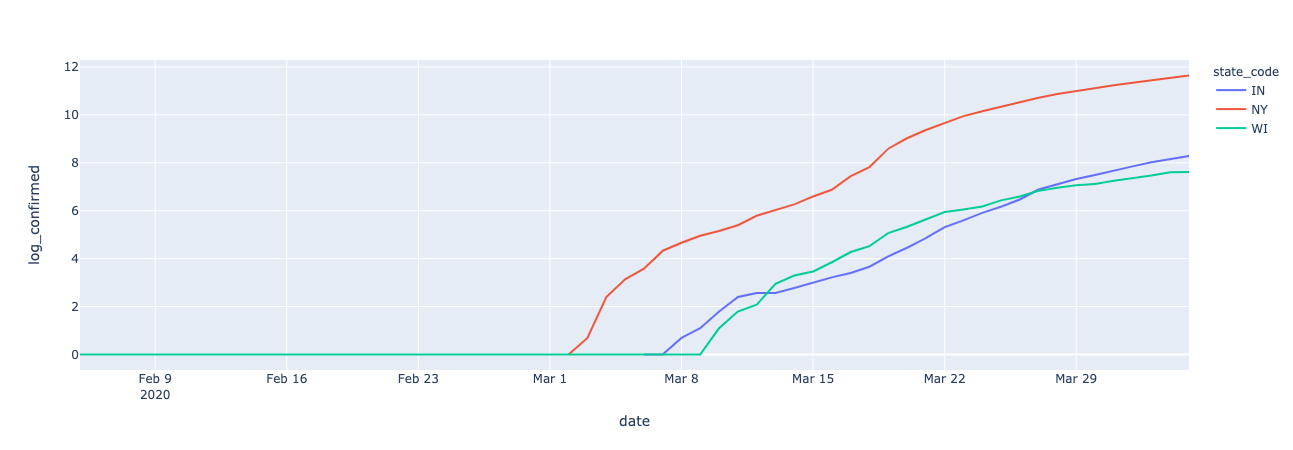

In [243]:
px.line(us_timeseries_cln.query('state_code in ("WI", "NY", "IN")')
        , x='date', y='log_confirmed', color='state_code')

In [264]:
databases

['austin_311',
 'austin_bikeshare',
 'austin_crime',
 'austin_incidents',
 'austin_waste',
 'baseball',
 'bitcoin_blockchain',
 'bls',
 'catalonian_mobile_coverage',
 'catalonian_mobile_coverage_eu',
 'census_bureau_acs',
 'census_bureau_construction',
 'census_bureau_international',
 'census_bureau_usa',
 'census_utility',
 'cfpb_complaints',
 'chicago_crime',
 'chicago_taxi_trips',
 'cloud_storage_geo_index',
 'cms_codes',
 'cms_medicare',
 'cms_synthetic_patient_data_omop',
 'covid19_jhu_csse',
 'covid19_jhu_csse_eu',
 'crypto_bitcoin',
 'crypto_bitcoin_cash',
 'crypto_dash',
 'crypto_dogecoin',
 'crypto_ethereum',
 'crypto_ethereum_classic',
 'crypto_litecoin',
 'crypto_zcash',
 'eclipse_megamovie',
 'epa_historical_air_quality',
 'ethereum_blockchain',
 'faa',
 'fcc_political_ads',
 'fda_drug',
 'fda_food',
 'fdic_banks',
 'fec',
 'fhir_synthea',
 'genomics_cannabis',
 'genomics_rice',
 'geo_census_blockgroups',
 'geo_census_tracts',
 'geo_international_ports',
 'geo_openstreetmap

## Examine Wisconsin Data

In [68]:
wisconsin_data = jhu_covid_summary \
    .query('province_state == "Wisconsin"') \
    .copy()

In [69]:
current_wisconsin_data = wisconsin_data[
    wisconsin_data['date'] == max_date
].copy()

In [70]:
current_wisconsin_data_cln = current_wisconsin_data[
    np.logical_and(current_wisconsin_data['fips'].notnull()
                   , current_wisconsin_data['admin2'] != 'Unassigned')
].copy()

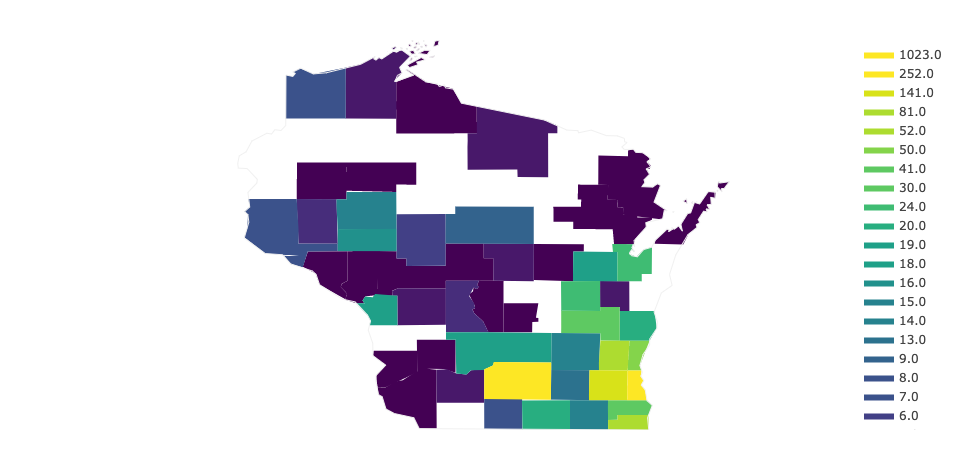

In [64]:
fig = ff.create_choropleth(fips=current_wisconsin_data_cln['fips']
                           , values=current_wisconsin_data_cln['confirmed']
                           , scope=['WI'])
fig.layout.template = None
fig.show()

In [76]:
dane_data = wisconsin_data \
    .query('admin2 == "Dane" or admin2 == "Milwaukee"') \
    .copy()

In [80]:
df2 = dane_data \
    .sort_values('date') \
    [['date','confirmed', 'admin2']] \
    .copy()

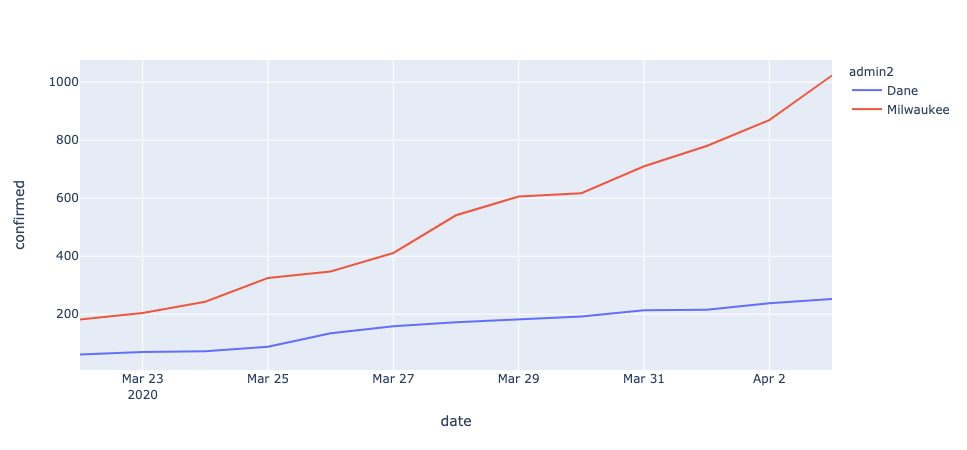

In [223]:
px.line(df2, x='date', y='confirmed', color='admin2')

In [201]:
df2.reset_index(col_fill='date')

,index,date,confirmed
0,37853,2020-03-22,61.0
1,37855,2020-03-23,70.0
2,37852,2020-03-24,72.0
3,37851,2020-03-25,88.0
4,37850,2020-03-26,134.0
5,37857,2020-03-27,158.0
6,37849,2020-03-28,172.0
7,37847,2020-03-29,183.0
8,37859,2020-03-30,192.0
9,37858,2020-03-31,214.0


## Create a new dataset

A dataset is contained within a specific [project](https://cloud.google.com/bigquery/docs/projects). Datasets are top-level containers that are used to organize and control access to your [tables](https://cloud.google.com/bigquery/docs/tables) and [views](https://cloud.google.com/bigquery/docs/views). A table or view must belong to a dataset. You need to create at least one dataset before [loading data into BigQuery](https://cloud.google.com/bigquery/loading-data-into-bigquery).

In [ ]:
# Define a name for the new dataset.
dataset_id = 'your_new_dataset'

# The project defaults to the Client's project if not specified.
dataset = client.create_dataset(dataset_id)  # API request

## Write query results to a destination table

For more information, see [Writing query results](https://cloud.google.com/bigquery/docs/writing-results) in the BigQuery documentation.

In [ ]:
sql = """
    SELECT corpus
    FROM `bigquery-public-data.samples.shakespeare`
    GROUP BY corpus;
"""
table_ref = dataset.table("your_new_table_id")
job_config = bigquery.QueryJobConfig(
    destination=table_ref
)

# Start the query, passing in the extra configuration.
query_job = client.query(sql, location="US", job_config=job_config)

query_job.result()  # Waits for the query to finish
print("Query results loaded to table {}".format(table_ref.path))

## Load data from a pandas DataFrame to a new table

In [ ]:
records = [
    {"title": "The Meaning of Life", "release_year": 1983},
    {"title": "Monty Python and the Holy Grail", "release_year": 1975},
    {"title": "Life of Brian", "release_year": 1979},
    {"title": "And Now for Something Completely Different", "release_year": 1971},
]

# Optionally set explicit indices.
# If indices are not specified, a column will be created for the default
# indices created by pandas.
index = ["Q24980", "Q25043", "Q24953", "Q16403"]
df = pandas.DataFrame(records, index=pandas.Index(index, name="wikidata_id"))

table_ref = dataset.table("monty_python")
job = client.load_table_from_dataframe(df, table_ref, location="US")

job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

## Load data from a local file to a table

The following example demonstrates how to load a local CSV file into a new table. See [SourceFormat](https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.job.SourceFormat.html#google.cloud.bigquery.job.SourceFormat) in the Python client library documentation for a list of available source formats. For more information, see [Loading Data into BigQuery from a local data source](https://cloud.google.com/bigquery/docs/loading-data-local) in the BigQuery documentation.

In [ ]:
source_filename = 'resources/us-states.csv'

table_ref = dataset.table('us_states_from_local_file')
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,
    autodetect=True
)

with open(source_filename, 'rb') as source_file:
    job = client.load_table_from_file(
        source_file,
        table_ref,
        location='US',  # Must match the destination dataset location.
        job_config=job_config)  # API request

job.result()  # Waits for table load to complete.

print('Loaded {} rows into {}:{}.'.format(
    job.output_rows, dataset_id, table_ref.path))

## Load data from Cloud Storage to a table

The following example demonstrates how to load a local CSV file into a new table. See [SourceFormat](https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.job.SourceFormat.html#google.cloud.bigquery.job.SourceFormat) in the Python client library documentation for a list of available source formats. For more information, see [Introduction to loading data from Cloud Storage](https://cloud.google.com/bigquery/docs/loading-data-cloud-storage) in the BigQuery documentation.

In [ ]:
# Configure the load job
job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField('name', 'STRING'),
        bigquery.SchemaField('post_abbr', 'STRING')
    ],
    skip_leading_rows=1,
    # The source format defaults to CSV. The line below is optional.
    source_format=bigquery.SourceFormat.CSV
)
uri = 'gs://cloud-samples-data/bigquery/us-states/us-states.csv'
destination_table_ref = dataset.table('us_states_from_gcs')

# Start the load job
load_job = client.load_table_from_uri(
    uri, destination_table_ref, job_config=job_config)
print('Starting job {}'.format(load_job.job_id))

load_job.result()  # Waits for table load to complete.
print('Job finished.')

# Retreive the destination table
destination_table = client.get_table(table_ref)
print('Loaded {} rows.'.format(destination_table.num_rows))

## Cleaning Up

The following code deletes the dataset created for this tutorial, including all tables in the dataset.

In [ ]:
# Retrieve the dataset from the API
dataset = client.get_dataset(client.dataset(dataset_id))

# Delete the dataset and its contents
client.delete_dataset(dataset, delete_contents=True)

print('Deleted dataset: {}'.format(dataset.path))

In [35]:
import d3py
import networkx as nx

import logging
logging.basicConfig(level=logging.DEBUG)

G = nx.Graph()
G.add_edge(1,2)
G.add_edge(1,3)
G.add_edge(3,2)
G.add_edge(3,4)
G.add_edge(4,2)

# use 'with' if you are writing a script and want to serve this up forever
with d3py.NetworkXFigure(G, width=500, height=500) as p:
    p += d3py.ForceLayout()
    p.show()

ModuleNotFoundError: No module named 'd3py'